<a href="https://colab.research.google.com/github/ricky-kiva/dl-deep-tf-cv-advanced/blob/main/1_a1_bboxes_birds_caltech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Localization on Caltech Birds**

Connecting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Set data path

In [2]:
DATA_DIR = '/content/drive/My Drive/Datasets/TF3 C3 W1 Data/'

Import packages

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

Set constants

In [34]:
IOU_THRESHOLD = 0.5
BATCH_SIZE = 64
EPOCHS = 50

Function: Dataset to numpy

In [5]:
def dataset_to_numpy(dataset, batch_size=0, N=0):

  take_dataset = dataset.shuffle(1024) # take first '1024' data, put into buffer, & randomly shuffle the data

  if batch_size > 0:
    take_dataset = take_dataset.batch(batch_size) # groups dataset elements into batches of size 'batch_size'

  if N > 0:
    take_dataset = take_dataset.take(N) # take the first `N` element

  print(f"Executing eagerly: {tf.executing_eagerly()}")
  if tf.executing_eagerly():
    ds_images, ds_bboxes = [], []

    # convert each data to numpy, assign to corresponding array
    for img, bbox in take_dataset:
      ds_images.append(img.numpy())
      ds_bboxes.append(bbox.numpy())

    return (np.array(ds_images, dtype=object),
            np.array(ds_bboxes, dtype=object))

Function: Read dataset images with original bounding box

In [6]:
def read_image_tfds_with_original_bbox(data):
  img = data['image']
  bbox = data['bbox']

  # in `tf.shape()`, the order is (height, width, channel)
  shape = tf.shape(img)
  factor_x = tf.cast(shape[1], tf.float32)
  factor_y = tf.cast(shape[0], tf.float32)

  # reverse normalization, multiplied by corresponding value (width or height)
  bbox_list = [bbox[1] * factor_x,
               bbox[0] * factor_y,
               bbox[3] * factor_x,
               bbox[2] * factor_y]

  return img, bbox_list

Function: Draw bounding boxes on image array

In [7]:
def draw_bbox_on_image(img, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
  cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

def draw_bboxes_on_image_array(img, boxes, color=[], thickness=5):
  boxes_shape = boxes.shape
  if not boxes_shape: # check whether it's an empty array
    return

  # check if it has 'pred' & 'actual' bboxes
  # check if 'bboxes' has size of 4 (xmin, ymin, xmax, ymax)
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')

  # `boxes_shape` has `shape` of `(2, 4)`. It iterates over the bounding boxes (2)
  for i in range(boxes_shape[0]):
    draw_bbox_on_image(img, boxes[i, 1], boxes[i, 0], boxes[i, 3], boxes[i, 2], color[i], thickness)

  return img

Function: Display digit images with boxes

In [33]:
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

  n = min(len(images), 10)

  fig = plt.figure(figsize=(20,4)) # make new figure
  plt.title(title) # set title
  plt.yticks([]) # disable ticks
  plt.xticks([])

  for i in range(n):
    ax = fig.add_subplot(1, n, (i+1)) # (row, column, subplot location)
    width, height, _ = images[i].shape

    # assign 'bboxes' to 'bboxes_to_plot' array
    bboxes_to_plot = []
    if len(pred_bboxes) > i:
      bbox = pred_bboxes[i]
      bbox = [bbox[0] * height,
              bbox[1] * width,
              bbox[2] * height,
              bbox[3] * width]
      bboxes_to_plot.append(bbox)

    if len(bboxes) > i:
      bbox = bboxes[i]
      if bboxes_normalized == True:
        bbox = [bbox[0] * height,
              bbox[1] * width,
              bbox[2] * height,
              bbox[3] * width]
      bboxes_to_plot.append(bbox)

    # draw bounding boxes
    img_to_draw = draw_bboxes_on_image_array(img=images[i],
                                             boxes=np.asarray(bboxes_to_plot),
                                             color=[(255,0,0), (0, 255, 0)])

    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_to_draw) # show the image on subplot

    # display IoU
    if len(iou) > i:
      color = 'black'
      if (iou[i][0] < IOU_THRESHOLD):
        color = 'red'

      # `ax.transAxes`: text positioning made relative to the axes
      ax.text(0.2, -0.3, f"IoU: {round((iou[i][0]), 2)}", color=color, transform=ax.transAxes)

Function: Get dataset for visualization ([Caltech Birds - 2010](http://www.vision.caltech.edu/visipedia/CUB-200.html))

In [9]:
import tensorflow_datasets as tfds

def get_viz_dataset(split_type='train'):
  dataset, info = tfds.load('caltech_birds2010', split=split_type, data_dir=DATA_DIR, download=False, with_info=True)

  if split_type == 'train':
    print(f"Dataset Info: {info}\n")

  # applies function `read_image_tfds_with_original_bbox()` to each element in the dataset
  # `num_parallel_calls=16`: process up to 16 elements in parallel
  viz_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)

  return viz_dataset

Instantiate train visualization dataset

In [10]:
viz_train_dataset = get_viz_dataset('train')

(viz_train_images, viz_train_bboxes) = dataset_to_numpy(viz_train_dataset)

Dataset Info: tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_dir='/content/drive/My Drive/Datasets/TF3 C3 W1 Data/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(sha

Visualize *train* dataset samples

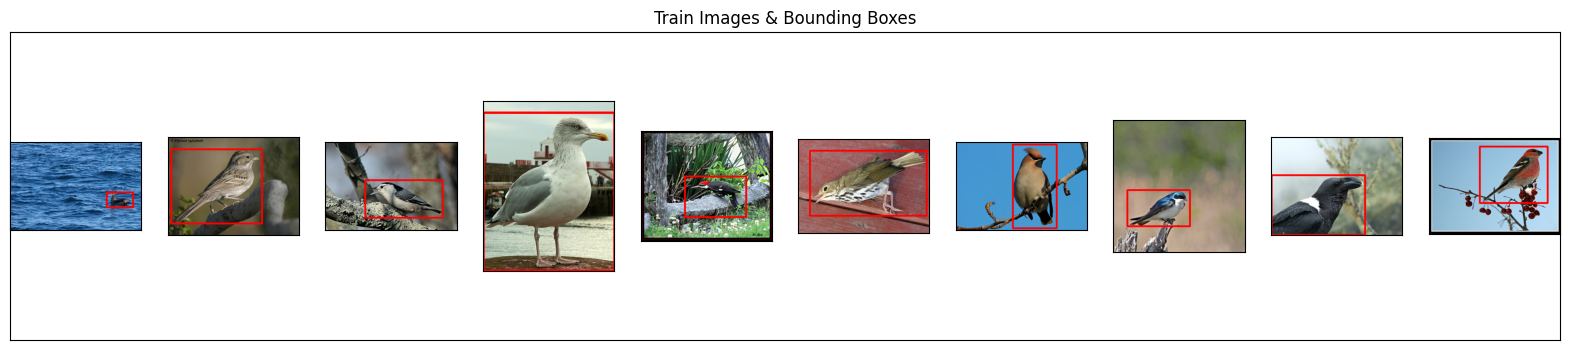

In [11]:
display_digits_with_boxes(images=np.array(viz_train_images),
                          pred_bboxes=np.array([]),
                          bboxes=np.array(viz_train_bboxes),
                          iou=np.array([]),
                          title="Train Images & Bounding Boxes")

Instantiate *validation* visualization dataset

In [12]:
viz_validation_dataset = get_viz_dataset('test')

(viz_validation_images, viz_validation_bboxes) = dataset_to_numpy(viz_validation_dataset)

Executing eagerly: True


Visualize *validation* dataset samples

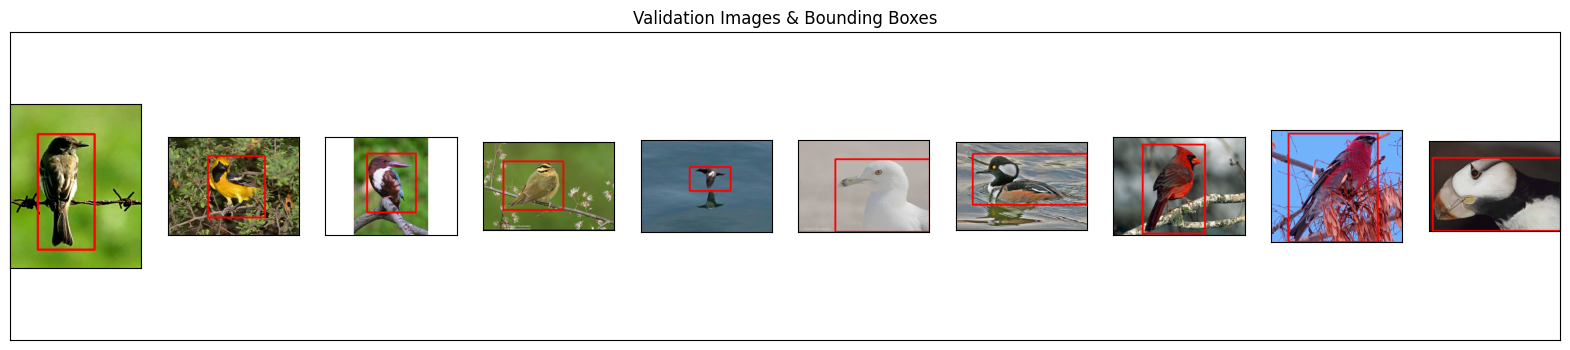

In [13]:
display_digits_with_boxes(images=np.array(viz_validation_images),
                          pred_bboxes=np.array([]),
                          bboxes=np.array(viz_validation_bboxes),
                          iou=np.array([]),
                          title="Validation Images & Bounding Boxes")

Function: Read image from dataset

In [14]:
def read_image_tfds(img, bbox):
  img = tf.cast(img, tf.float32)
  shape = tf.shape(img)

  # in `tf.shape()`, the order is (height, width, channel)
  factor_x = tf.cast(shape[1], tf.float32)
  factor_y = tf.cast(shape[0], tf.float32)

  img = tf.image.resize(img, (224, 224,))

  # normalize to range [-1, 1] (commonly [0, 2], (divided by 255))
  # - use this normalization because we use `MobileNetV2`
  img = img / 127.5
  img -= 1

  bbox_list = [bbox[0] / factor_x,
               bbox[1] / factor_y,
               bbox[2] / factor_x,
               bbox[3] / factor_y]

  return img, bbox_list

**Note:**
- [0, 2] Normalization:
  - Advantages:
    - Simple transformation: keeps all data points in positive range
  - Disadvantages:
    - Not centered around zero: can potentially slow down learning process
- [-1, 1] Normalization:
  - Advantages:
    - Symmetry: many activation functions (ex: tanh) are symmetric around zero. it leads to better performance & stability in training
  - Disadvantages:
    - Requires adjustment: need to scale then shift the data

- **Explanation**, when data not centered around zero:
  - many activation functions (sigmoid, tanh, etc) sensitive if around zero.
    - When input far from zero, it tends to saturate  (gradients become very small). This makes learning slow
  - if all inputs are positive & not centered, gradients can all move in same direction, making network hard to adjust weight to capture complex patterns
    - complex patterns often need to adjust weights in very specific wys (increasing some while decreasing others), if gradients push adjustments only in the same direction (always positive/negative), the process will become challenging
  - gradient descent could easily adjust weights on both positive & negative directions when data is centered around zero

Function: Get *train* dataset

In [15]:
def get_train_dataset(dataset):
  # applies function `read_image_tfds()` to each element in the dataset
  dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

  # params: (buffer size, reshuffle_each_iteration)
  # `reshuffle_each_iteration`: if `.repeat()` executed, dataset will be shuffled again
  dataset = dataset.shuffle(512, reshuffle_each_iteration=True) # take first '512' data, put into buffer, & randomly shuffle the data

  # MANDATORY FOR KERAS
  # repeats indefinitely. ensure dataset doesn't run out of data when training
  dataset = dataset.repeat()

  # groups dataset elements into batches of size BATCH_SIZE
  dataset = dataset.batch(BATCH_SIZE)

  # fetch (prepare) next batches while processing current batches
    # params: (buffer_size). `-1` allows Tensorflow to automatically tune prefetch 'buffer size'
  dataset = dataset.prefetch(-1)

  return dataset

Function: Get *validation* dataset

In [16]:
def get_validation_dataset(dataset):
  dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

  # why `batch()` first before `repeat()` in validation?
  # - `batch()` sets the size of each step of validation
  # - `repeat()` allows multiple epochs of validation without manual intervention
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.repeat() # MANDATORY FOR KERAS

  return dataset

Instantiate dataset

In [17]:
train_dataset = get_train_dataset(viz_train_dataset)
validation_dataset = get_validation_dataset(viz_validation_dataset)

**Note:** we'll use [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2) with following conditions:
- we'll use pretrained `imagenet` *weights* as starting point for further training
- we'll **re-train** all layers of MobileNetV2
- `input_shape`: (224, 224, 3)

Model: Feature extractor

In [18]:
def feature_extractor(inputs):

  # instantiate MobileNetV2 object
  mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                                                   include_top=False,
                                                                   weights='imagenet')

  # pass inputs to the object
  feature_extractor = mobilenet_model(inputs)

  return feature_extractor

Model: Fully connected layers

In [19]:
def dense_layers(features):

  # computes the average of each feature map's elements
  # - resulting single value per feature maps
  # - the output is 1D tensor with N elements (N = number of feature maps)
  x = tf.keras.layers.GlobalAveragePooling2D()(features)

  # GPT tell `Flatten` after `GlobalAveragePooling2D` is redundant
  # - because `GlobalAveragePooling2D` itself outputs '1D tensor'
  # convert a multi-dimensional tensor into 1D tensor
  x = tf.keras.layers.Flatten()(x)

  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)

  return x

Model: Bounding Box Regression

In [20]:
def bounding_box_regression(x):

  # `units` to set `Dense` layer to output 4 values
  bounding_box_regression_output = tf.keras.layers.Dense(units=4,
                                                         name='bounding_box')(x)

  return bounding_box_regression_output

Model: Final Model

In [21]:
def final_model(inputs):
  feature_cnn = feature_extractor(inputs)
  last_dense_layer = dense_layers(feature_cnn)
  bounding_box_output = bounding_box_regression(last_dense_layer)

  # only outputs bounding box, not with classification (for this case)
  model = tf.keras.Model(inputs=inputs,
                         outputs=[bounding_box_output])

  return model

**Note on using `SGD` with `momentum`**:
- **SGD shines in scenarios:**
  - **large data**: datasets that are too big to fit entirely into computer's memory at once (relative). But datasets that are several gigabytes are considered 'large'
  - **sparse data**: majority of the elements in dataset are zeros / have no data. in context of image data (bounding box):
    - **sparse annotations**: not all parts of an image might be relevant for identifying & predicting their bounding boxes. this can be considered as *sparse*, as they apply limited regions of the image
    - **sparse output space**: when setting bounding box, in reality, only a few segments that occupy the desired object. this can be considered as *sparse*
    - **sparse feature maps**: when many activations are zero/near zero, indicating only certain features of the image are being highlighted as relevant for making predictions
  - **computational efficiency of incremental updates is important:** if learning based on small batch of data at a time is used (usage of mini-batch)

- **SGD with Momentum:**
  - **Basic Idea:** push model's training faster towards the minimum by accumulating a fraction (`momentum` param.) of previous gradients in each update
      - So, it also considers the **velocity** of the provious steps, instead of just current gradient
      - `velocity = momentum * 0 - learning_rate * gradient`. *initially, velocity = 0*
      - `w = w + momentum * velocity - learning_rate * gradient`
  - **Advantages:**
    - **Faster convergence**: momentum can speed up learning, especially on flat surfaces (gradient is small)
    - **Smooth out gradient variations**: momentum represents a more stable direction of descent. making optimization less sensitive to noisy gradients
    - **Helps escape local minima**: momentum helps escape local minima that SGD might get stuck in
  - **Disadvantages:**
    - **Potentially overshooting:** if momentum value is too high, there's risk of  overshooting the minimum
    - **Hyperparameter tuning:** momentum is an additional hyperparameter that needs to be selected carefully


Model: Compile the model

In [22]:
def define_and_compile_model():

  # define input layer
  inputs = tf.keras.Input(shape=(224, 224, 3)) # follow `MobileNetV2` req.

  # create the model
  model = final_model(inputs)

  # compile the model
  model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                loss='mse')

  return model

Define the model

In [23]:
model = define_and_compile_model()
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                

Set `steps_per_epoch` & `validation_steps` to cover the whole dataset

**Note:** If number of samples is not evenly divisible by the *BATCH_SIZE*, try to calculate the number of steps (`steps_per_epoch` & `validation_steps`) to train all the full batches PLUS 1 more batch containing the remaining from the non-evenly division

In [24]:
import math

length_of_train_dataset = len(viz_train_dataset)
length_of_validation_dataset = len(viz_validation_dataset)
print(f"Train dataset length: {length_of_train_dataset}\nValidation dataset length: {length_of_validation_dataset}")

# we will use 2 example of different ways to ensure all samples in dataset is covered

# 1. `math.ceil` approach
STEPS_PER_EPOCH = math.ceil(length_of_train_dataset / BATCH_SIZE)
print(f"steps_per_epoch: {STEPS_PER_EPOCH}")

# 2. `if conditional` approach
VALIDATION_STEPS = length_of_validation_dataset // BATCH_SIZE # `//` is floor division
if (length_of_validation_dataset % BATCH_SIZE) > 0:
  VALIDATION_STEPS += 1

print(f"validation_steps: {VALIDATION_STEPS}")

Train dataset length: 3000
Validation dataset length: 3033
steps_per_epoch: 47
validation_steps: 48


Train the model

In [25]:
history = model.fit(train_dataset,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=validation_dataset,
                    validation_steps=VALIDATION_STEPS,
                    epochs=EPOCHS)

Epoch 1/50
47/47 [==============================] - 48s 535ms/step - loss: 0.0942 - val_loss: 0.3115
Epoch 2/50
47/47 [==============================] - 22s 464ms/step - loss: 0.0176 - val_loss: 0.2597
Epoch 3/50
47/47 [==============================] - 33s 707ms/step - loss: 0.0128 - val_loss: 0.2085
Epoch 4/50
47/47 [==============================] - 22s 479ms/step - loss: 0.0102 - val_loss: 0.1746
Epoch 5/50
47/47 [==============================] - 22s 470ms/step - loss: 0.0085 - val_loss: 0.1452
Epoch 6/50
47/47 [==============================] - 33s 705ms/step - loss: 0.0073 - val_loss: 0.1328
Epoch 7/50
47/47 [==============================] - 22s 483ms/step - loss: 0.0064 - val_loss: 0.1063
Epoch 8/50
47/47 [==============================] - 33s 705ms/step - loss: 0.0060 - val_loss: 0.0917
Epoch 9/50
47/47 [==============================] - 33s 708ms/step - loss: 0.0052 - val_loss: 0.0809
Epoch 10/50
47/47 [==============================] - 23s 499ms/step - loss: 0.0049 - val_lo

Validate the model

In [26]:
loss = model.evaluate(validation_dataset, steps=VALIDATION_STEPS)
print(f"Loss: {loss}")

48/48 [==============================] - 9s 181ms/step - loss: 0.0184
Loss: 0.01843755878508091


Function: Plot metrics

In [27]:
def plot_metrics(history, metric_name, title, ylim=1):
  plt.title(title)
  plt.ylim(0, ylim)
  plt.plot(history.history[metric_name], color='blue', label=metric_name)
  plt.plot(history.history[f"val_{metric_name}"], color='green', label=f"val_{metric_name}")

Plot loss metric

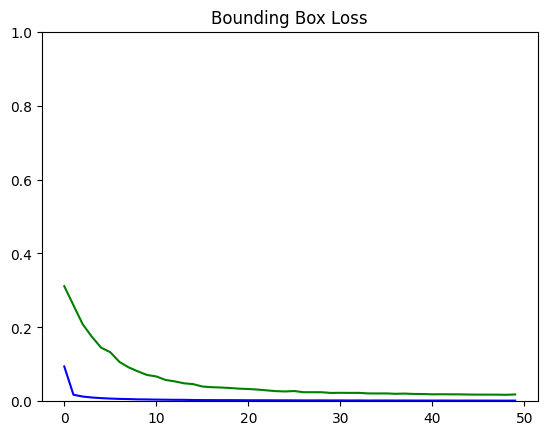

In [28]:
plot_metrics(history, 'loss', 'Bounding Box Loss')

Function: Display Intersection over Union (IoU)

In [29]:
def intersection_over_union(pred_box, true_box):
  # `np.split()`: split array into multiple sub-array
  xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis=1)
  xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis=1)

  smoothing_factor = 1e-10

  # get intersection value for each x & y
  xmin_overlap = np.maximum(xmin_pred, xmin_true)
  xmax_overlap = np.minimum(xmax_pred, xmax_true)
  ymin_overlap = np.maximum(ymin_pred, ymin_true)
  ymax_overlap = np.minimum(ymax_pred, ymax_true)

  # get area of prediction & true box
  pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
  true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

  # get overlapping area (intersection)
  overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0) * np.maximum((ymax_overlap - ymin_overlap), 0)

  # get union area
  union_area = (pred_box_area + true_box_area) - overlap_area

  iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

  return iou

Function: Dataset to numpy with original bounding boxes

In [30]:
# read image from Tensorflow Dataset but also return original image
def read_image_with_shape(img, bbox):
  original_img = img

  img, bbox_list = read_image_tfds(img, bbox)

  return original_img, img, bbox_list

def dataset_to_numpy_with_original_bboxes(dataset, batch_size=0, N=0):

  normalized_dataset = dataset.map(read_image_with_shape)

  if batch_size > 0:
    normalizd_dataset = normalized_dataset.batch(batch_size)

  if N > 0:
    normalized_dataset = normalized_dataset.take(N)

  ds_original_images, ds_images, ds_bboxes = [], [], []

  if tf.executing_eagerly():
    for original_images, images, bboxes in normalized_dataset:
      ds_original_images.append(original_images.numpy())
      ds_images.append(images.numpy())
      ds_bboxes.append(bboxes.numpy())

  return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

Make bounding box predictions

In [36]:
(original_images,
 normalized_images,
 normalized_bboxes) = dataset_to_numpy_with_original_bboxes(viz_validation_dataset, N=500)

# make predictions
predicted_bboxes = model.predict(normalized_images, batch_size=BATCH_SIZE)

# calculate IoU
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)

print(f"IoU > threshold: {(iou >= IOU_THRESHOLD).sum()}")
print(f"IoU < threshold: {(iou < IOU_THRESHOLD).sum()}")

<ipython-input-30-cd3e1dd7f22d>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)


8/8 [==============================] - 1s 90ms/step
IoU > threshold: 243
IoU < threshold: 257


Visualize bounding box predictions

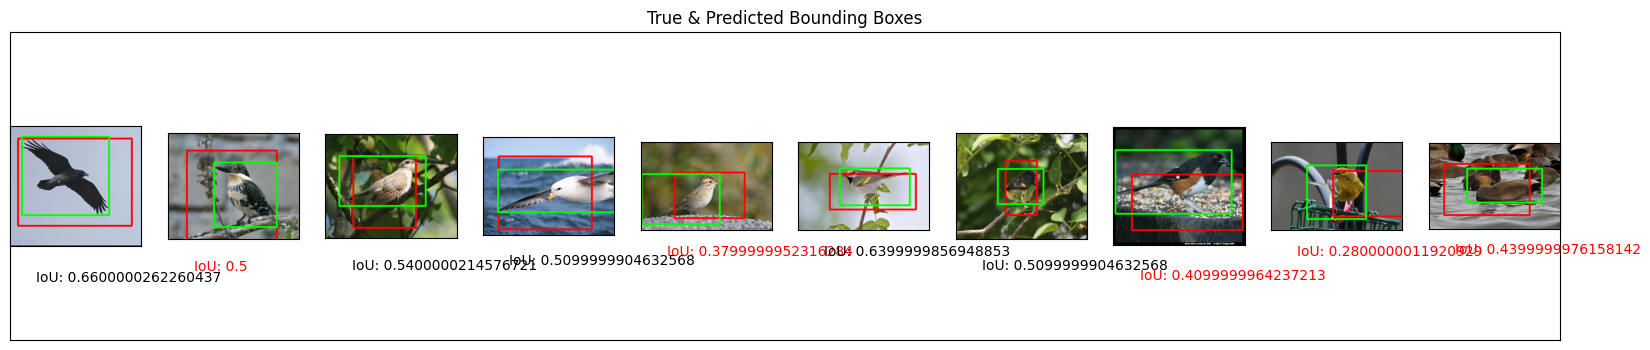

In [37]:
# get 10 random indexes
indexes = np.random.choice(len(predicted_bboxes), size=10)

iou_to_draw = iou[indexes]
img_to_draw = original_images[indexes]

display_digits_with_boxes(img_to_draw,
                          predicted_bboxes[indexes],
                          normalized_bboxes[indexes],
                          iou_to_draw,
                          "True & Predicted Bounding Boxes",
                          bboxes_normalized=True)